#### Loan Approval Prediction
* About Dataset
    * The loan approval dataset contains financial records and associated information used to determine the eligibility of individuals for obtaining loans. 
* Objective 
    * To predict the likelihood of loan approval based on given features. 
    * Classes - Approve, and reject.
* Download dataset from https://www.kaggle.com/datasets/altruistdelhite04/loan-prediction-problem-dataset


In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

#### Read Data

In [2]:
# Get current directory
current_dir = os.getcwd()
# Join current directory with the path having training dataset
file_path = os.path.join(current_dir,"storage/input/train_u6lujuX_CVtuZ9i.csv")
train_df = pd.read_csv(file_path)
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
# Join current directory with the path having test dataset
file_path = os.path.join(current_dir,"storage/input/test_Y3wMUE5_7gLdaTN.csv")
test_df = pd.read_csv(file_path)
test_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [4]:
# Get column names in training data
print(train_df.columns)
# Print shape of training data
print("Shape of training data: ", train_df.shape)
# Print out the no: of unique Loan id
print('No. of unique loan id: ', len(train_df["Loan_ID"].unique()))

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')
Shape of training data:  (614, 13)
No. of unique loan id:  614


* The training data consists of 12 independent variables (features columns) and 1 target variable (Loan_Status).
* There are 614 records in training dataset.
* There aren't any duplicate Loan_ID and each row has unique Loan ID

In [5]:
# Get column names in test data
print(test_df.columns)
# Print shape of test data
print("Shape of test data: ", test_df.shape)
# Print out the no: of unique Loan id
print('No. of unique loan id: ', len(test_df["Loan_ID"].unique()))

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')
Shape of test data:  (367, 12)
No. of unique loan id:  367


* Test data consists of same feature columns as training data. But, It doesn't contain target variable (Loan_Status). We need to train machine learning model to predict Loan_Status
* There are 367 records in test dataset.
* There aren't duplicate records in test dataset.

##### Print information about training dataframe including dtype, columns, non-null values and memory usage

In [6]:
# print content information in train_df
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None


* From above info, there are missing values in some features - Gender, Married, Dependents, Self_Employed, LoanAmount, Loan_Amount_Term and Credit_history because their non-null count values are less than total records, 614.
* From above info, 
    * Only CoapplicantIncome, LoanAmount and Loan_Amount_Term are numerical data and other features are categorical data.

##### Find out more about missing values

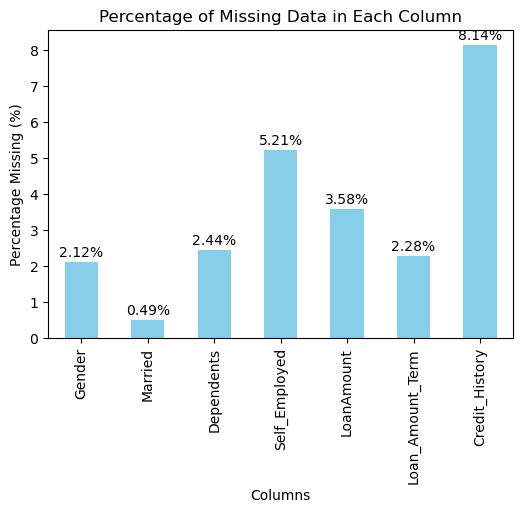

In [7]:
# Calculate percentage of missing data in each column
missing_percentage = train_df.isnull().mean()*100
# Plot the bar chart with annotation
plt.figure(figsize=(6,4))
bars = missing_percentage[missing_percentage>0].plot(kind='bar', color='skyblue')
# Add annotation to each bar
for bar in bars.patches:
    plt.text(
        bar.get_x()+bar.get_width()/2,
        bar.get_height()+0.15,
        f"{bar.get_height():.2f}%",
        ha="center",
        color="black"
    )
plt.title("Percentage of Missing Data in Each Column")
plt.xlabel("Columns")
plt.ylabel("Percentage Missing (%)")
plt.show()

* Credit history has the most missing value followed by self employed, loan amount, dependents, and so on.

#### Descriptive statistics and Pairs plot
* Generate descriptive statistics for numerical data including central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

In [8]:
# Generate descriptive statistics
train_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


##### PairPlot

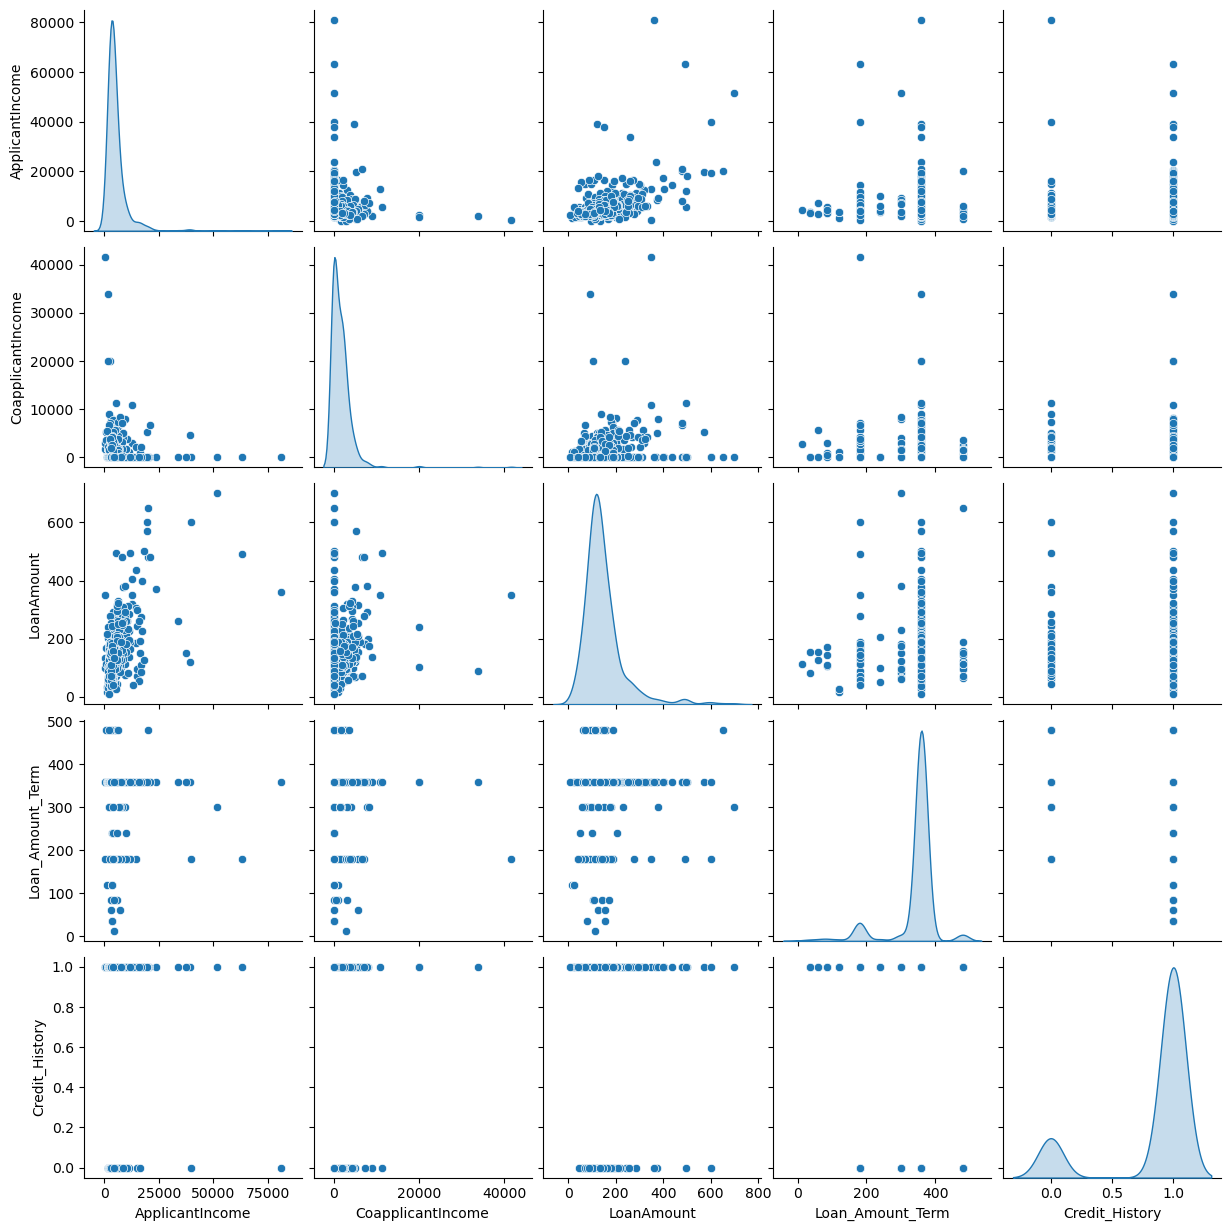

In [9]:
# Creating a pair plot
# Extracting only numerical columns for the pair plot
numerical_columns = train_df.select_dtypes(include='number')
sns.pairplot(numerical_columns, diag_kind='kde')
plt.show()

* From above pair plot, there seems to have positive correlation between loan amount and applicant income.
* From the probability distribution, applicant income, coapplicant income and loan amount in the distribution is toward left (Right skewed). This could be due to outliers in data.

##### Correlation analysis

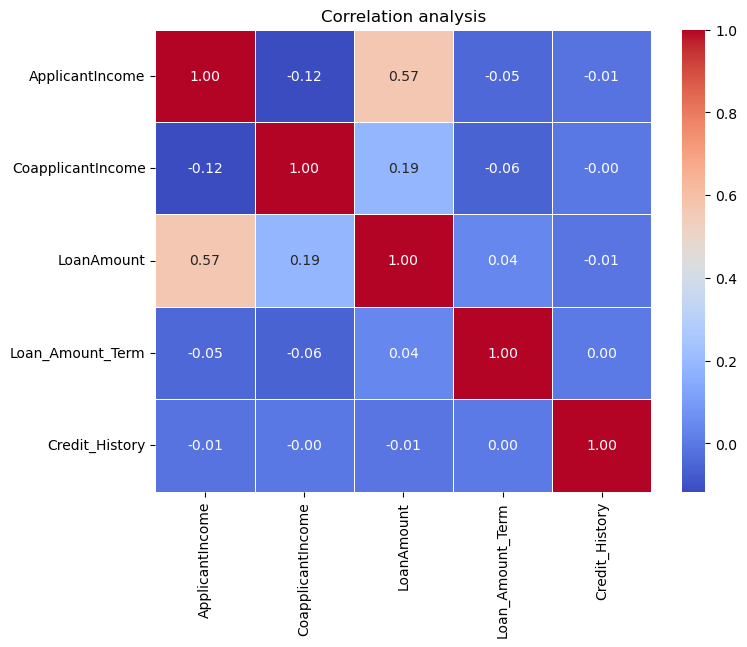

In [10]:
corr_matrix = numerical_columns.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation analysis")
plt.show()

* From the correlation analysis, applicant income and loan amount have moderate positive correlation, which correlation between other variables have very weak relationship.

#### Descriptive analysis of categorical and ordinal data

##### Norminal Data

Text(0.5, 0, 'Education')

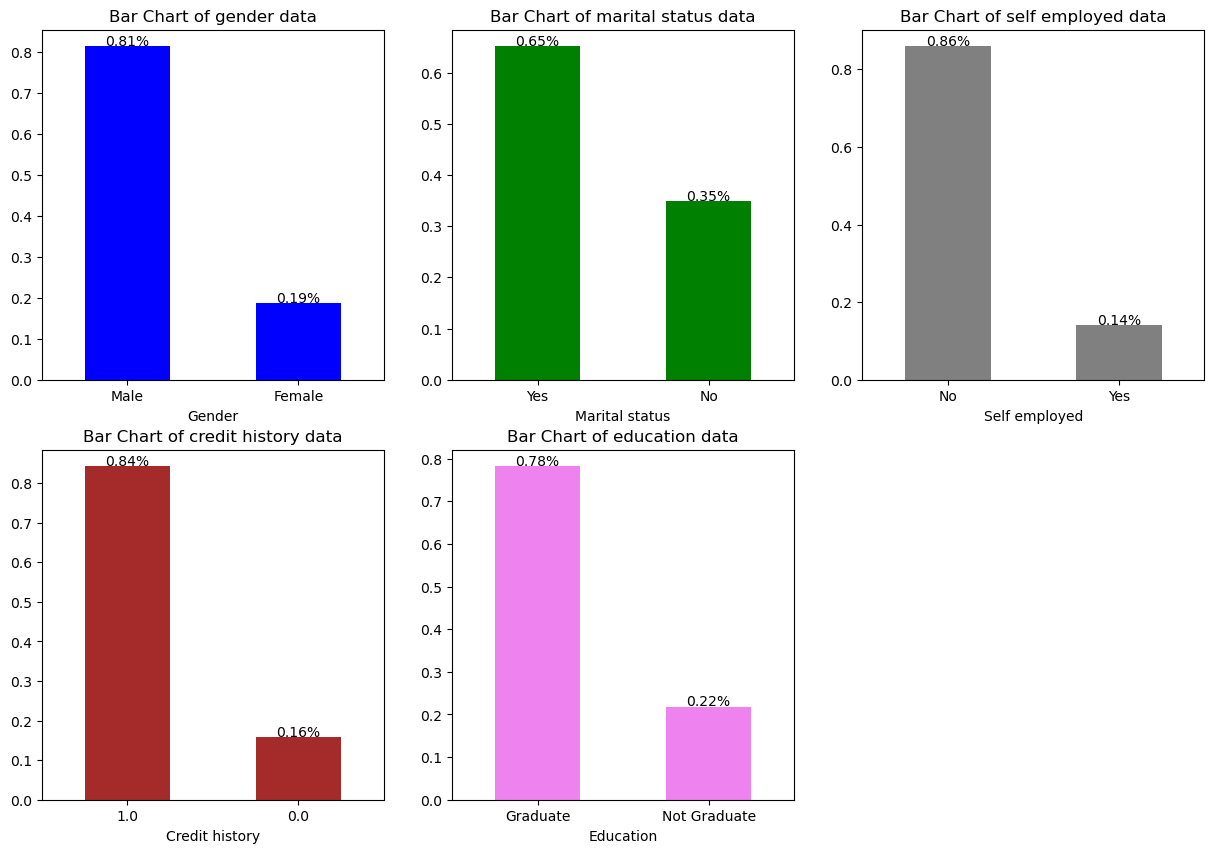

In [11]:
# Descriptive analysis of Norminal data
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
bars=train_df['Gender'].value_counts(normalize=True).plot(kind='bar', color='blue', rot=0)
# Add annotation to each bar
for bar in bars.patches:
    plt.text(
        bar.get_x()+bar.get_width()/2,
        bar.get_height()+0.0025,
        f"{bar.get_height():.2f}%",
        ha="center",
        color="black"
    )
plt.title("Bar Chart of gender data")
plt.xlabel("Gender")

plt.subplot(2,3,2)
bars=train_df['Married'].value_counts(normalize=True).plot(kind='bar', color='green', rot=0)
# Add annotation to each bar
for bar in bars.patches:
    plt.text(
        bar.get_x()+bar.get_width()/2,
        bar.get_height()+0.0025,
        f"{bar.get_height():.2f}%",
        ha="center",
        color="black"
    )
plt.title("Bar Chart of marital status data")
plt.xlabel("Marital status")

plt.subplot(2,3,3)
bars=train_df['Self_Employed'].value_counts(normalize=True).plot(kind='bar', color='grey', rot=0)
# Add annotation to each bar
for bar in bars.patches:
    plt.text(
        bar.get_x()+bar.get_width()/2,
        bar.get_height()+0.0025,
        f"{bar.get_height():.2f}%",
        ha="center",
        color="black"
    )
plt.title("Bar Chart of self employed data")
plt.xlabel("Self employed")

plt.subplot(2,3,4)
bars=train_df['Credit_History'].value_counts(normalize=True).plot(kind='bar', color='brown', rot=0)
# Add annotation to each bar
for bar in bars.patches:
    plt.text(
        bar.get_x()+bar.get_width()/2,
        bar.get_height()+0.0025,
        f"{bar.get_height():.2f}%",
        ha="center",
        color="black"
    )
plt.title("Bar Chart of credit history data")
plt.xlabel("Credit history")

plt.subplot(2,3,5)
bars=train_df['Education'].value_counts(normalize=True).plot(kind='bar', color='violet', rot=0)
# Add annotation to each bar
for bar in bars.patches:
    plt.text(
        bar.get_x()+bar.get_width()/2,
        bar.get_height()+0.0025,
        f"{bar.get_height():.2f}%",
        ha="center",
        color="black"
    )
plt.title("Bar Chart of education data")
plt.xlabel("Education")


* According to bar chart of different features, most of the applicants are married men with university degrees who have repaied debts.

##### Ordinal Data

Text(0.5, 0, 'Property Area')

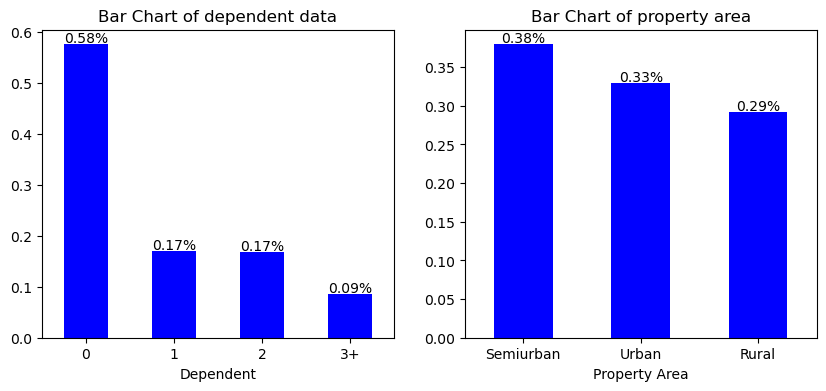

In [12]:
# Descriptive analysis of ordinal data
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
bars=train_df['Dependents'].value_counts(normalize=True).plot(kind='bar', color='blue', rot=0)
# Add annotation to each bar
for bar in bars.patches:
    plt.text(
        bar.get_x()+bar.get_width()/2,
        bar.get_height()+0.003,
        f"{bar.get_height():.2f}%",
        ha="center",
        color="black"
    )
plt.title("Bar Chart of dependent data")
plt.xlabel("Dependent")

plt.subplot(1,2,2)
bars=train_df['Property_Area'].value_counts(normalize=True).plot(kind='bar', color='blue', rot=0)
# Add annotation to each bar
for bar in bars.patches:
    plt.text(
        bar.get_x()+bar.get_width()/2,
        bar.get_height()+0.003,
        f"{bar.get_height():.2f}%",
        ha="center",
        color="black"
    )
plt.title("Bar Chart of property area")
plt.xlabel("Property Area")

* Based on the bar chart, most of the applicants don't have dependent and stay in semiurban area.

##### Bivariate Analysis

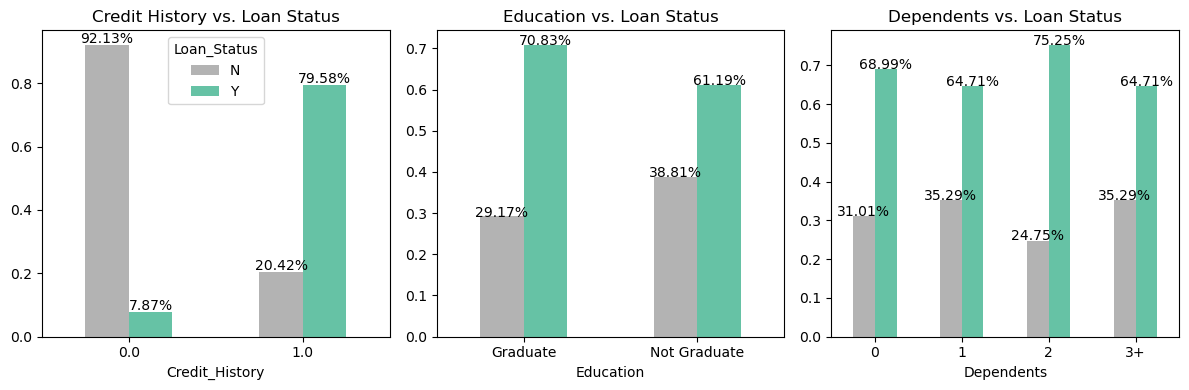

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
# Bivariate analysis between credit history and loan status
credit_history_counts = train_df.groupby(['Credit_History', 'Loan_Status']).size().unstack('Loan_Status')
# Normalize credit history counts
credit_history_counts_normalized = credit_history_counts.div(credit_history_counts.sum(axis=1), axis=0)
# Plot barchart
credit_history_counts_normalized.plot(kind='bar', stacked=False, ax=axes[0], colormap='Set2_r', rot=0)
# Annotate the barchart
for p in axes[0].patches:
    height=p.get_height()
    axes[0].annotate(f'{height:.2%}', (p.get_x() + p.get_width() / 2., height-0.025),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
axes[0].set_title('Credit History vs. Loan Status')

# Bivariate analysis between education and loan status
education_counts = train_df.groupby(['Education', 'Loan_Status']).size().unstack('Loan_Status')
# Normalize counts
education_counts_normalized = education_counts.div(education_counts.sum(axis=1), axis=0)
# Plot barchart
education_counts_normalized.plot(kind='bar', stacked=False, ax=axes[1], colormap='Set2_r', rot=0)
# Annotate the barchart
for p in axes[1].patches:
    height=p.get_height()
    axes[1].annotate(f'{height:.2%}', (p.get_x() + p.get_width() / 2., height-0.025),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
axes[1].set_title('Education vs. Loan Status')
# Turn off legend in the second subplot (axes[1]) because it covers annotation
axes[1].legend().set_visible(False)

# Bivariate analysis between dependents and loan status
dependents_counts = train_df.groupby(['Dependents', 'Loan_Status']).size().unstack('Loan_Status')
# Normalize counts
dependents_counts_normalized = dependents_counts.div(dependents_counts.sum(axis=1), axis=0)
# Plot barchart
dependents_counts_normalized.plot(kind='bar', stacked=False, ax=axes[2], colormap='Set2_r', rot=0)
# Annotate barchart
for p in axes[2].patches:
    height=p.get_height()
    axes[2].annotate(f'{height:.2%}', (p.get_x() + p.get_width() / 2., height-0.025),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
axes[2].set_title('Dependents vs. Loan Status')
# Turn off legend in the third subplot (axes[2]) because it covers annotation
axes[2].legend().set_visible(False)

plt.tight_layout()
plt.show()

* Credit history vs Loan status
    * Applicants who had already paid debt have higher chance of getting loan approval than those with debts.
* Education vs Loan status
    * Applicants who have university degree have higher chance of getting loan approval than those without degree.
* Dependents vs Loan status
    * Applicants who have 2 dependents have higher chance of getting loan approval than other categories.

#### Divide train_df into training dataset (80%) and validation dataset (20%)

In [14]:
X = train_df.copy()
y = X[['Loan_Status']]
X = X.drop('Loan_Status', axis=1)

# Split the dataset into training and validation sets (80% training, 20% validation in this example)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop Loan_ID column
X_train = X_train.drop('Loan_ID', axis=1)
X_val = X_val.drop('Loan_ID', axis=1)

####################### One hot encoding and missing values imputation #########################
# Separate numerical and categorical features
numerical_features = X_train.select_dtypes(include=['float', 'int']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Create separate imputation pipelines for numerical and categorical features
numerical_pipeline = Pipeline(steps=[
    ('imputer', IterativeImputer(max_iter=10, random_state=42))
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Use 'most_frequent' for simplicity
    ('encoder', OneHotEncoder())
])
# Create a column transformer to apply different imputation methods to numerical and categorical features
imputation = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

# Create a final pipeline
pipeline = Pipeline(steps=[
    ('imputation', imputation)])
# Fit and transform the data
Xtrain_imputed = pipeline.fit_transform(X_train)

# Display the imputed data
imputed_train_df = pd.DataFrame(Xtrain_imputed, 
                                columns=numerical_features.tolist() + pipeline.named_steps['imputation'].transformers_[1][1]['encoder'].get_feature_names_out(categorical_features).tolist())
imputed_train_df.head(10)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,6000.0,2250.0,265.0,360.0,0.853686,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,2958.0,2900.0,131.0,360.0,1.000000,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,6250.0,1695.0,210.0,360.0,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,2083.0,3150.0,128.0,360.0,1.000000,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,4166.0,0.0,98.0,360.0,0.000000,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5,19730.0,5266.0,570.0,360.0,1.000000,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
6,3333.0,2166.0,130.0,360.0,0.842335,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
7,3365.0,1917.0,112.0,360.0,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
8,3625.0,0.0,108.0,360.0,1.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
9,9508.0,0.0,187.0,360.0,1.000000,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [15]:
# Fit and transform the data
Xval_imputed = pipeline.transform(X_val)

# Display the imputed data
imputed_val_df = pd.DataFrame(Xval_imputed, 
                                columns=numerical_features.tolist() + pipeline.named_steps['imputation'].transformers_[1][1]['encoder'].get_feature_names_out(categorical_features).tolist())
imputed_val_df.head(10)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,9083.0,0.0,228.0,360.0,1.000000,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,4310.0,0.0,130.0,360.0,0.847543,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,4167.0,1447.0,158.0,360.0,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,2900.0,0.0,71.0,360.0,1.000000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,2718.0,0.0,70.0,360.0,1.000000,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5,1782.0,2232.0,107.0,360.0,1.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
6,3717.0,0.0,120.0,360.0,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
7,3000.0,0.0,66.0,360.0,1.000000,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
8,2647.0,1587.0,173.0,360.0,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
9,1000.0,3022.0,110.0,360.0,1.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [16]:
# Calculate percentage of missing data in each column in training dataset after imputation
missing_percentage = imputed_train_df.isnull().mean()*100
if len(missing_percentage[missing_percentage>0])==0:
    print("No missing values in training dataset")
else:
    print("There are missing values in training dataset")

# Calculate percentage of missing data in each column in validation dataset after imputation
missing_percentage = imputed_val_df.isnull().mean()*100
if len(missing_percentage[missing_percentage>0])==0:
    print("No missing values in validation dataset")
else:
    print("There are missing values in validation dataset")


No missing values in training dataset
No missing values in validation dataset


In [17]:
# Map target variable: 'Y' to 1 and 'N' to 0
y_train = y_train['Loan_Status'].map({'Y': 1, 'N': 0})
y_val = y_val['Loan_Status'].map({'Y':1, 'N':0})

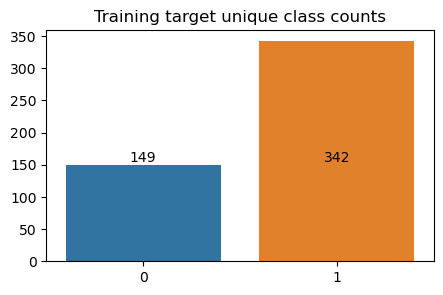

In [18]:
# Visualize total number of unique class in target variable
cls_count = {}
plt.figure(figsize=(5,3))
# Counts unique class value
class_counts = y_train.value_counts()
# Plot bar chart of different class count
ax = sns.barplot(x=class_counts.index, y=class_counts.values)
# Add values above bars
for i, v in zip(class_counts.index, class_counts.values):
    ax.text(i, 150, str(v), ha='center', va='bottom')
    cls_count[str(i)] = v
plt.title('Training target unique class counts')
# Show the plot
plt.show()

* From above bar chart, class 1 is about 2.3 time larger than class 0. The dataset is imbalance.
* To handle imbalance dataset, weighted loss is used during training of Random Forest classifier. The method assigns different weights to different classes, giving more importance to the minority class. 

In [24]:
# Calculate the scale positive weight based on the class distribution
pos_weight = cls_count["0"]/cls_count["1"]

# Create a XGboost with class weights
xgb_clf = XGBClassifier(scale_pos_weight=pos_weight)

# Hyper-parameters to be tuned
params = {'eta': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
        'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 250, 500, 1000, 5000],
        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# Define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# Random search parameter tuning
random_search = RandomizedSearchCV(estimator = xgb_clf, 
                                param_distributions=params, 
                                n_jobs=-1, 
                                cv=cv, 
                                scoring='roc_auc', 
                                verbose=3)
        
result = random_search.fit(imputed_train_df.values, y_train.to_numpy())
# Report best configuration
print("Best: %f using %s "% (result.best_score_, result.best_params_))
result = {'Best_f1-score_of_hyperparameter_tuning': result.best_score_,
        'n_estimators': result.best_params_['n_estimators'],
        'max_depth': result.best_params_['max_depth'],
        'eta': result.best_params_['eta']}

# extract best parameters
n_estimators = result['n_estimators']
max_depth = result['max_depth']
eta = result['eta']

# train xgboost classifier
xgb_clf = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, eta=eta, scale_pos_weight=pos_weight)

# Fit the classifier to the training data
xgb_clf.fit(imputed_train_df.values, y_train.to_numpy())

# Make predictions on the test set
y_pred = xgb_clf.predict(imputed_val_df.values)

Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best: 0.763737 using {'n_estimators': 80, 'max_depth': 1, 'eta': 0.1} 


##### Model Evaluation
* Model performance is evaluated by using Area Under the Receiver Operating Characteristic, AU-ROC, curve for both training and validation set.
* Balanced accuracy score

Test balanced accuracy:  0.7084302325581395


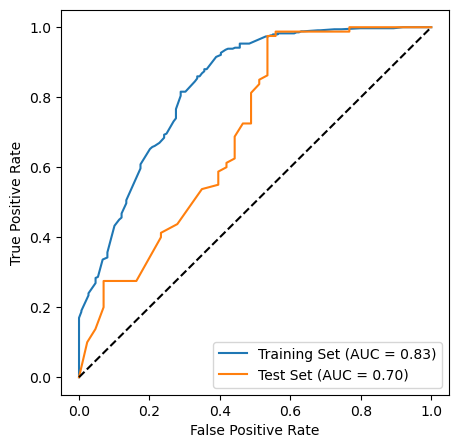

In [25]:
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score

print('Test balanced accuracy: ',balanced_accuracy_score(y_val.to_numpy(), y_pred))

# Train
ytrain_pred_proba = xgb_clf.predict_proba(imputed_train_df.values)[:,1]
fpr_train, tpr_train, _ = metrics.roc_curve(y_train.to_numpy(),  ytrain_pred_proba)
auc_train = metrics.roc_auc_score(y_train.to_numpy(), ytrain_pred_proba)

# Test
ytest_pred_proba = xgb_clf.predict_proba(imputed_val_df.values)[:,1]
fpr_val, tpr_val, _ = metrics.roc_curve(y_val.to_numpy(),  ytest_pred_proba)
auc_val = metrics.roc_auc_score(y_val.to_numpy(), ytest_pred_proba)

#create ROC curve
plt.figure(figsize=(5,5))
plt.plot(fpr_train, tpr_train, label=f'Training Set (AUC = {auc_train:.2f})')
plt.plot(fpr_val, tpr_val, label=f'Test Set (AUC = {auc_val:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()